# Data Preparation

In this step, the original dataset is transformed to a form that is more suitable for training and evaluating models. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("../datasets/data.csv")

display(df.head(), df.shape)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Anthony Smith,Khalil Rountree Jr.,Mark Smith,2023-12-09,"Las Vegas, Nevada, USA",Blue,False,LightHeavyweight,0.846558,0.003906,0.513517,0.442042,0.000000,0.013328,0.000977,0.000122,0.000000,0.000000,91.936035,37.195679,88.720215,41.244995,93.035400,38.033447,92.940186,44.925903,0.125000,0.000000,1.404053,0.065430,73.664795,22.621338,67.108032,23.292358,10.156006,7.614380,12.142578,9.675049,8.115234,6.959961,9.469604,8.277588,84.911133,32.224121,85.758179,39.245361,4.540649,3.426392,2.648438,1.780273,2.484253,1.545166,0.313599,0.219360,17.937744,4.995972,413.148804,26,1,0,2,4,8,6,0,0.0,1.0,1.0,6.0,0.0,0.0,Southpaw,185.42,193.04,205.0,0.125420,0.011841,0.538892,0.401560,0.264596,0.284723,0.081066,0.000002,0.000017,0.015686,105.356533,59.717880,155.639414,60.519283,106.912781,61.244738,165.833305,68.061056,2.421747,0.770084,0.928648,0.353144,68.010708,29.193089,118.783186,32.606531,13.347809,9.542440,17.966904,10.427622,23.998016,20.982351,18.889324,17.485130,103.846695,58.651762,140.668631,49.713648,0.803675,0.524130,2.329470,1.785358,0.706163,0.541988,12.641314,9.020277,62.802755,79.061634,778.111862,50,1,0,1,3,12,8,0,0.0,1.0,1.0,5.0,4.0,1.0,Orthodox,193.04,193.04,205.0,33.0,35.0
1,Song Kenan,Kevin Jousset,Mark Smith,2023-12-09,"Las Vegas, Nevada, USA",Blue,False,Welterweight,0.000000,0.000000,0.500000,0.660000,1.000000,0.000000,1.000000,0.000000,0.0000

(7424, 144)

## 1. Winner Class Imbalance

During the EDA, we found that the [UFC stats website](http://ufcstats.com/statistics/events/completed?page=all) reported fight wins by assigning the fighter who won, irrespective of favourite/underdog, to the red corner, prior to 2010. This changed from 3/21/2010 onwards, as the red/blue color was now used to assign the favourite/underdog, respectively. Therefore, we can simply search for the first occurrence of the blue corner winning, and discard the entries prior to this fight. Alternatively, we can augment the dataset by scraping betting odds from before 2010 and renaming the columns accordingly. The former method was chosen, because there does not seem to be a central data source from which to scrape betting odds prior to 2010. 

In [3]:
first_blue_win = (df['Winner'] == 'Blue')[::-1].idxmax()
df_balanced = df.iloc[:first_blue_win+1, :]
df_balanced['Winner'].value_counts(normalize=True)

Red     0.572104
Blue    0.407854
Draw    0.020042
Name: Winner, dtype: float64

## 2. Imputing missing values and selecting features

The dataset contains many missing values distributed over many features. This is problematic if we naively discard the instances containing missing values, because the size of the dataset will decrease too much. Therefore, we opt for an imputation strategy. First, let us divide the features in non-numeric and numeric sets.

In [182]:
df_balanced_cat = df_balanced.select_dtypes(exclude='number')
df_balanced_num = df_balanced.select_dtypes(include='number')

### 2.1. Non-numeric imputation

For the non-numeric features, there are only 4 features that need to be addressed. 

<AxesSubplot: >

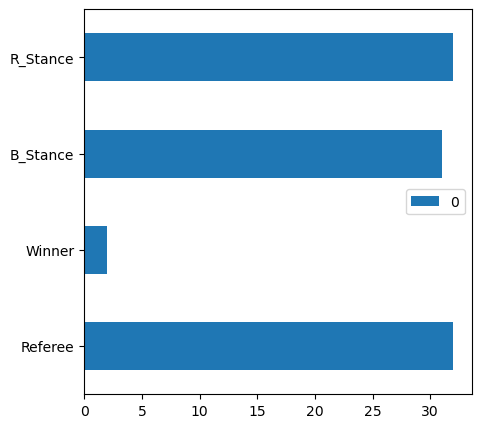

In [183]:
cat_missing = df_balanced_cat.isna().sum()
cat_missing = pd.DataFrame(cat_missing.iloc[np.where(cat_missing > 0)])
cat_missing.plot(kind='barh', figsize=(5, 5))

Looking at the non-numeric data types, we see that there are some missing values in the `Referee` column, in the `R_Stance`/`B_Stance` columns, and in the target `Winner` column. As we saw during EDA, the distribution of the amount of fights called by referees is skewed towards the referee Herb Dean. Therefore, it may be a safe assumption to just impute the missing values with the most likely value, "Herb Dean".

In [184]:
df_balanced_cat['Referee'] = df_balanced_cat['Referee'].fillna('Herb Dean')
df_balanced_cat.isna().sum()

R_fighter        0
B_fighter        0
Referee          0
date             0
location         0
Winner           2
title_bout       0
weight_class     0
B_Stance        31
R_Stance        32
dtype: int64

Next, let us look at the missing values of the `Winner` feature. There are only two missing values, so let us inspect these cases. 

In [185]:
df_balanced[df_balanced_cat['Winner'].isna()]

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
651,Chad Anheliger,Alatengheili,Herb Dean,2022-09-10,"Las Vegas, Nevada, USA",NaN,False,Bantamweight,0.0,0.0,0.28,0.395,0.0,0.185,0.0,0.5,0.0,0.0,144.5,41.0,189.0,76.5,145.5,41.5,191.0,78.0,0.5,0.0,4.5,1.5,121.0,24.5,142.5,44.5,16.0,10.5,34.0,23.0,7.5,6.0,12.5,9.0,143.0,40.5,180.0,72.0,1.5,0.5,4.0,1.0,0.0,0.0,5.0,3.5,3.0,61.5,900.0,6,0,0,2,0,0,2,0,0.0,0.0,0.0,0.0,0.0,0.0,Orthodox,165.10,167.64,135.0,2.0,0.0,0.510,0.500,0.00,0.570,2.0,0.0,0.0,0.0,130.0,67.0,126.0,64.0,156.0,92.0,135.0,73.0,1.0,0.0,7.0,4.0,110.0,53.0,64.0,17.0,13.0,7.0,39.0,26.0,7.0,7.0,23.0,21.0,90.0,40.0,112.0,51.0,22.0,13.0,14.0,13.0,18.0,14.0,0.0,0.0,80.0,200.0,813.0,3,0,1,0,1,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,Orthodox,167.64,162.56,135.0,30.0,35.0
2163,Wu Yanan,Mizuki,Thomas Fan,2019-08-31,"Shenzhen, Guangdong, China",NaN,False,WomenFlyweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Orthodox,160.02,165.10,115.0,0.0,0.0,0.465,0.485,0.25,0.355,0.5,0.0,0.0,0.0,43.5,20.0,54.0,27.5,59.0,34.5,155.0,114.5,1.5,0.5,4.0,2.5,26.0,7.5,38.5,16.0,9.5,6.5,12.0,9.0,8.0,6.0,3.5,2.5,33.0,12.0,34.0,12.5,10.0,7.5,14.0,10.5,0.5,0.5,6.0,4.5,155.5,261.0,570.0,4,0,0,1,1,1,1,0,0.0,0.0,0.0,0.0,1.0,0.0,Orthodox,172.72,167.6

We can see that the `Winner` column is indeed missing, even though there was definitely a conclusive result to this match. The UFC stats website even reported on it:
- [Anheliger vs. Alatengheili](http://ufcstats.com/fight-details/6010f681e54ba2cd)
- [Yanan vs. Mizuki](http://ufcstats.com/fight-details/5f900e4437e079b3)

Therefore, we can assign the missing values manually for these cases. 

In [186]:
df_balanced_cat.at[651, 'Winner'] = 'Blue'
df_balanced_cat.at[2163, 'Winner'] = 'Red'

df_balanced_cat.isna().sum()

R_fighter        0
B_fighter        0
Referee          0
date             0
location         0
Winner           0
title_bout       0
weight_class     0
B_Stance        31
R_Stance        32
dtype: int64

Next, we can look at the two remaining categorical missing features, i.e., the stance feature. For these, it makes sense to impute by using the mode average of the categorical variable.

In [187]:
mode_r_stance = df_balanced_cat['R_Stance'].value_counts().index[0]
df_balanced_cat['R_Stance'] = df_balanced_cat['R_Stance'].fillna(mode_r_stance)

mode_r_stance = df_balanced_cat['B_Stance'].value_counts().index[0]
df_balanced_cat['B_Stance'] = df_balanced_cat['B_Stance'].fillna(mode_r_stance)

df_balanced_cat.isna().sum()

R_fighter       0
B_fighter       0
Referee         0
date            0
location        0
Winner          0
title_bout      0
weight_class    0
B_Stance        0
R_Stance        0
dtype: int64

One last issue that needs to be addressed is inconsistencies of the names of certain fighters. For example, in the dataset, if Aoriqileng is fighting in the red corner, his name is " Aoriqileng", whereas in the blue corner, there is no whitespace at the front. Therefore, we trim the fighter names for consistency. This will be useful in the following data cleaning steps. 

In [193]:
df_balanced_cat = df_balanced_cat.replace('^\s+', '', regex=True) # trim whitespace in front of the name
df_balanced_cat = df_balanced_cat.replace('\s+$', '', regex=True) # trim whitespace at the end of the name

### 2.2. Numeric imputation

From the EDA, we know that the missing values in the dataset are partly due to a fighter making his/her debut, and therefore not having any statistics on previous fights registered *within* the UFC. 

<AxesSubplot: >

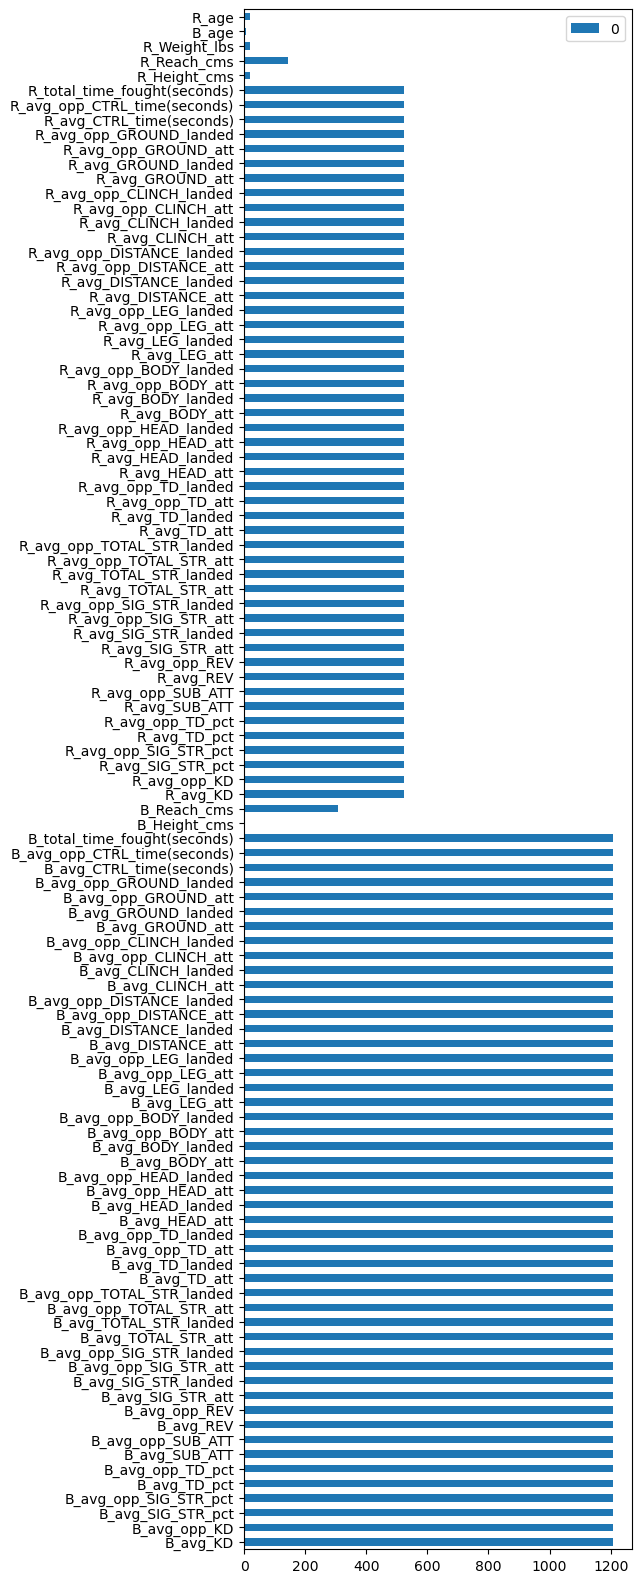

In [194]:
num_missing = df_balanced_num.isna().sum()
num_missing = pd.DataFrame(num_missing.iloc[np.where(num_missing > 0)])
num_missing.plot(kind='barh', figsize=(5, 20))

As can be seen in the above plot and was seen during EDA, there are some associations between the missingness of variables. Therefore, we would like to handle missingness with respect to a group of variables for which their missingness depends on each other. The `df_balanced_num` dataframe is further partitioned based on the features that are missing together, and the features that behave differently with regard to missing values. 

In [447]:
other_missing_num_cols = ['R_age', 'R_Weight_lbs', 'R_Reach_cms', 'R_Height_cms', 'B_age', 'B_Weight_lbs', 'B_Reach_cms', 'B_Height_cms']

df_other_num = df_balanced_num[other_missing_num_cols]
df_fight_num = df_balanced_num.drop(columns=other_missing_num_cols)

We start with the "other" numerical missing values. The idea is as follows:
1. for each unique fighter
2. aggregate the relevant features from both the red corner fights and the blue corner fights
3. sort index to get history of a specific fighter
4. to impute `age`, use `date` to derive what the age of the fighter would have been. If there is no age/date reference, simply impute with the mean age.
5. to impute `Reach_cms`, `Weight_lbs`, `Height_cms`, either:
   - impute with the mean if the entire column of the fighter history is missing, or
   - impute with the **Missing Forest** imputation model, that uses Random Forests 

In [448]:
import sklearn.neighbors._base 
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
pd.options.mode.chained_assignment = None  # default='warn'

fighters = pd.unique(df_balanced_cat[['R_fighter', 'B_fighter']].values.ravel())

# Precompute means of features
other_num_means = {
    'age': pd.melt(df_other_num[['R_age', 'B_age']], value_vars=['R_age', 'B_age'])['value'].mean(),
    'Weight_lbs': pd.melt(df_other_num[['R_Weight_lbs', 'B_Weight_lbs']], value_vars=['R_Weight_lbs', 'B_Weight_lbs'])['value'].mean(),
    'Reach_cms': pd.melt(df_other_num[['R_Reach_cms', 'B_Reach_cms']], value_vars=['R_Reach_cms', 'B_Reach_cms'])['value'].mean(),
    'Height_cms': pd.melt(df_other_num[['R_Height_cms', 'B_Height_cms']], value_vars=['R_Height_cms', 'B_Height_cms'])['value'].mean(),
}

for fighter in fighters:
    idx_r = df_balanced_cat[(df_balanced_cat['R_fighter'] == fighter)].index
    idx_b = df_balanced_cat[(df_balanced_cat['B_fighter'] == fighter)].index

    red_cols = df_other_num.filter(regex=("^R_.*$")).iloc[idx_r, :]
    red_cols['R_date'] = df_balanced_cat.loc[idx_r, 'date'].apply(lambda x: int(x.split('-')[0]))
    blue_cols = df_other_num.filter(regex=("^B_.*$")).iloc[idx_b, :]
    blue_cols['B_date'] = df_balanced_cat.loc[idx_b, 'date'].apply(lambda x: int(x.split('-')[0]))

    red_cols.columns = [c[2:] for c in red_cols.columns]
    blue_cols.columns = [c[2:] for c in blue_cols.columns]

    # combine all stats for a specific fighter in one dataframe, sorted by index
    # creates fight history for specific fighter
    combined_df = pd.concat([red_cols, blue_cols]).sort_index()

    # check for NaN values in 'age' column
    if combined_df['age'].isna().any():
        
        # get all non-NaN pairs of age and date 
        age_years = combined_df[combined_df['age'].notnull() & combined_df['date'].notnull()]

        # check if there is at least one pair
        if age_years.shape[0] > 0:

            # take first age/date pair as reference for imputation
            ref_age, ref_year = age_years.iloc[0][['age', 'date']]
            # impute using reference age and year w.r.t. the dates of the matches
            imputed_age = [ref_age - (ref_year - combined_df['date'].iloc[i]) if np.isnan(a) else a for i, a in enumerate(combined_df['age'])]
            combined_df['age'] = pd.Series(imputed_age, index=combined_df.index)
        else:
            # If there is no reference age/date, then simply impute using the mean
            combined_df['age'] = combined_df['age'].fillna(other_num_means['age'])

        df_other_num.iloc[idx_r, :red_cols.shape[1]-1] = combined_df.loc[idx_r, :].values[:, :-1]
        df_other_num.iloc[idx_b, blue_cols.shape[1]-1:] = combined_df.loc[idx_b, :].values[:, :-1]

    # weight, reach, height are taken together because they are correlated
    if combined_df[['Weight_lbs', 'Reach_cms', 'Height_cms']].isna().any().any():
        missing_wrh = combined_df[['Weight_lbs', 'Reach_cms', 'Height_cms']]
        
        # if one of the columns only has NaN values, then impute with the mean 
        for c in missing_wrh:
            if missing_wrh[c].isna().sum() == combined_df.shape[0]:
                missing_wrh[c] = missing_wrh[c].fillna(other_num_means[c])

        # if there are still NaNs, impute using missing forest 
        if missing_wrh.isna().any().any():
            missing_wrh = MissForest(criterion='squared_error', n_estimators=30).fit_transform(missing_wrh)
            missing_wrh = pd.DataFrame(missing_wrh, index=combined_df.index)
            
        df_other_num.loc[idx_r, ['R_Weight_lbs', 'R_Reach_cms', 'R_Height_cms']] = missing_wrh.loc[idx_r, :].values
        df_other_num.loc[idx_b, ['B_Weight_lbs', 'B_Reach_cms', 'B_Height_cms']] = missing_wrh.loc[idx_b, :].values

df_other_num.isna().sum()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 0
Iteration: 1
Iteration: 2


R_age           0
R_Weight_lbs    0
R_Reach_cms     0
R_Height_cms    0
B_age           0
B_Weight_lbs    0
B_Reach_cms     0
B_Height_cms    0
dtype: int64

With regard to the missing fighter statistics, we can run a similar algorithm. We already know that one part of the missing values is due to fighters who are participating in their debut match. Therefore, we go through each fighter, and aggregate all of their fights by combining the blue corner matches and the red corner matches. Then, we look at their first fight, which is easily accessible since the dataset is ordered, and should be missing. If this fight happened after the 2010 cut-off, we need to deal with the `NaN` values. The following approaches were tried, but did not succeed:
- **Linear regression model**: This did not produce sensible results for a sample of fighters, mainly because we cannot guarantee that column vectors behave linearly. 
- **Spline interpolation**: Using `df.interpolate(method='spline', order=k)` leads to many negative values and outliers, because piece-wise polynomials of order `k` are fitted on the target `NaN` column values. 
- **Time series interpolation**: Using `df.interpolate(method='time')` did not produce something sensible. The reason being that since the `NaN` values are the first entry in the time series, i.e., at $t=0$, the data of all subsequent fights is used to predict $t=0$. However, this just leads to using the same values as the next entry at $t=1$. 
- **Missing Forest**: This takes into account the entire column which results in inconsistencies. We can hypothesize that the first few fights in the organisation are more dependent, because a fighter needs to be established in the rankings and therefore, the stakes are higher if he/she loses. 

After these approaches were tried and evaluated, the imputation approach was chosen to simply replace the `NaNs` by the mean of the first 3 fights, i.e., mean of $t=1, t=2, t=3$. After inspection of a random sample, the values seem to be consistent with the expectations of certain fighters.    

In [449]:
fighters = pd.unique(df_balanced_cat[['R_fighter', 'B_fighter']].values.ravel())

limited_fight_history = []

for fighter in fighters:
    idx_r = df_balanced_cat[(df_balanced_cat['R_fighter'] == fighter)].index
    idx_b = df_balanced_cat[(df_balanced_cat['B_fighter'] == fighter)].index

    red_fighter_cols = df_fight_num.filter(regex=("^R_.*$")).iloc[idx_r, :]
    blue_fighter_cols = df_fight_num.filter(regex=("^B_.*$")).iloc[idx_b, :]

    red_fighter_cols.columns = [c for c in range(red_fighter_cols.shape[1])]
    blue_fighter_cols.columns = [c for c in range(blue_fighter_cols.shape[1])]

    # combine all stats for a specific fighter in one dataframe, sorted by index
    combined_df = pd.concat([red_fighter_cols, blue_fighter_cols]).sort_index()

    # if there is only 1 entry, then we cannot imput by using 3 time steps
    if combined_df.shape[0] == 1 and combined_df.isna().any().any():
        # save these for further inspection 
        limited_fight_history.append(fighter)
    else:
        # impute the debut fight stats using the mean of the first three fights
        combined_df = combined_df.fillna(combined_df.iloc[-3:].mean())

        df_fight_num.iloc[idx_b, :blue_fighter_cols.shape[1]] = combined_df.loc[idx_b, :].values
        df_fight_num.iloc[idx_r, blue_fighter_cols.shape[1]:] = combined_df.loc[idx_r, :].values

df_fight_num.isna().sum()

B_avg_KD                        119
B_avg_opp_KD                    119
B_avg_SIG_STR_pct               119
B_avg_opp_SIG_STR_pct           119
B_avg_TD_pct                    119
                               ... 
R_win_by_Decision_Split           0
R_win_by_Decision_Unanimous       0
R_win_by_KO/TKO                   0
R_win_by_Submission               0
R_win_by_TKO_Doctor_Stoppage      0
Length: 126, dtype: int64

We can see that there are still some entries with missing values. The reason is evident if we inspect the `limited_fight_history` list.

In [452]:
len(limited_fight_history), limited_fight_history[0]

(177, 'Rayanne Amanda')

In [456]:
display(df_balanced[(df_balanced_cat['R_fighter'] == limited_fight_history[0])])
display(df_balanced[(df_balanced_cat['B_fighter'] == limited_fight_history[0])])

display(df_balanced[(df_balanced_cat['R_fighter'] == limited_fight_history[1])])
display(df_balanced[(df_balanced_cat['B_fighter'] == limited_fight_history[1])])

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
8,Rayanne Amanda,Talita Alencar,Keith Peterson,2023-12-09,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Orthodox,154.94,147.32,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Orthodox,157.48,157.48,115.0,33.0,28.0


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age


,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Stance,B_Height_cms,B_Reach_cms,B_Weight_lbs,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
8,Rayanne Amanda,Talita Alencar,Keith Peterson,2023-12-09,"Las Vegas, Nevada, USA",Blue,False,WomenStrawweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Orthodox,154.94,147.32,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,Orthodox,157.48,157.48,115.0,33.0,28.0


We can see that these fighters have had only a single match in the organisation. Therefore, our strategy to use the mean of the first 3 fights did not work. An additional step is required. Since there is no information to go off on, it seems arbitrary to choose an imputation strategy for these cases. We opt for the `MissForest` model in this case, as it s precise, requires no assumptions on the distributional aspects of the data, nor any tuning of parameters. 

In [464]:
mf = MissForest(criterion='squared_error', oob_score=True)
df_fight_num_imputed = mf.fit_transform(df_fight_num)
df_fight_num_imputed = pd.DataFrame(df_fight_num_imputed, columns=df_fight_num.columns)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4


### 2.3. Combining imputed dataframes and saving results

In [474]:
df_imputed = pd.concat([df_balanced_cat, df_other_num, df_fight_num_imputed], axis=1)
df_imputed.isna().sum().sum()

0

In [483]:
df_imputed.to_csv('../datasets/data_imputed.csv', index=False)

## 3. Dataset Cleaning

There are still a few cleaning steps that we need to go through, so get a dataset that is ready for modeling. We first read the imputed dataset. 

In [509]:
df_imputed = pd.read_csv('../datasets/data_imputed.csv')
df_imputed.head()

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_Stance,R_Stance,R_age,R_Weight_lbs,R_Reach_cms,R_Height_cms,B_age,B_Weight_lbs,B_Reach_cms,B_Height_cms,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage
0,Anthony Smith,Khalil Rountree Jr.,Mark Smith,2023-12-09,"Las Vegas, Nevada, USA",Blue,False,LightHeavyweight,Southpaw,Orthodox,35.0,205.0,193.04,193.04,33.0,205.0,193.04,185.42,0.846558,0.003906,0.513517,0.442042,0.000000,0.013328,0.000977,0.000122,0.000000,0.000000,91.936035,37.195679,88.720215,41.244995,93.035400,38.033447,92.940186,44.925903,0.125000,0.000000,1.404053,0.065430,73.664795,22.621338,67.108032,23.292358,10.156006,7.614380,12.142578,9.675049,8.115234,6.959961,9.469604,8.277588,84.911133,32.224121,85.758179,39.245361,4.540649,3.426392,2.648438,1.780273,2.484253,1.545166,0.313599,0.219360,17.937744,4.995972,413.148804,26.0,1.0,0.0,2.0,4.0,8.0,6.0,0.0,0.0,1.0,1.0,6.0,0.0,0.0,0.125420,0.011841,0.538892,0.401560,0.264596,0.284723,0.081066,0.000002,0.000017,0.015686,105.356533,59.717880,155.639414,60.519283,106.912781,61.244738,165.833305,68.061056,2.421747,0.770084,0.928648,0.353144,68.010708,29.193089,118.783186,32.606531,13.347809,9.542440,17.966904,10.427622,23.998016,20.982351,18.889324,17.485130,103.846695,58.651762,140.668631,49.713648,0.803675,0.524130,2.329470,1.785358,0.706163,0.541988,12.641314,9.020277,62.802755,79.061634,778.111862,50.0,1.0,0.0,1.0,3.0,12.0,8.0,0.0,0.0,1.0,1.0,5.0,4.0,1.0
1,Song Kenan,Kevin Jousset,Mark Smith,2023-12-09,"Las Vegas, Nevada, USA",Blue,False,Welterweight,Orthodox,Orthodox,33.0,170.0,180.34,182.88,30.

### 3.1. Drop `R_draw` and `B_draw` columns

As we concluded from the EDA, the scraping and feature engineering of the `R_draw` and `B_draw` columns was incorrectly implemented, which results in two vectors consisting of only zeros. Therefore, they do not provide any information towards the target variable, and we can safely drop these features. 

In [510]:
df_imputed = df_imputed.drop(columns=['R_draw', 'B_draw'])

### 3.2. Label encoding `Winner`

The `Winner` target variable consists of 3 classes, i.e., `Red`, `Blue`, and `Draw`. Since a draw is only ever assigned to a match, for which the judges were not able to come to a decision with respect to one of the corners, it can by itself be seen as a classification problem, where the 3 judges are the classifiers. In the case of a draw, this would be analogous to predicting that either corner is as likely to win, i.e., with a probability of 50%. Therefore, we can encode the `Winner` class in a similar manner, so that the multi-class classification problem reduces to a binary classification problem.  

In [514]:
df_imputed['Winner'] = df_imputed['Winner'].replace({'Blue': -1, 'Red': 1, 'Draw': 0})

### 3.3. Drop `date` and `Referee`

Although the features related to the name of the fighter are not useful for the subsequent task of modeling, they are however still useful to keep around for evaluation explanations from the models. The `date` feature can be safely dropped. The `Referee` feature is highly dominated by one active referee, "Herb Dean", and so it does not make sense to one-hot encode 197 different referees as additional columns. 

In [515]:
df_imputed = df_imputed.drop(columns=['Referee', 'date'])

### 3.4. Clustering `location`

The location of the event at which matches take place may have an effect on the performance of the fighters. This effect can be described two-fold. First, the venue itself and the energy of the  crowd can affect fighters. In the same vain, whether a match takes place on home turf or in another country/continent. And second, the possible altitude and climate can affect the performance of the fighters, as stated in the [Medium](https://medium.com/@archie.fenn/ufc-278-how-altitude-affects-fighter-performance-26d8c0483307) article. 

For this analysis, we can make the simplifying assumption that these differences are only felt on the level of countries, rather than states and cities. Therefore, we re-cluster the `location` feature, so that it only consists of countries.  

In [516]:
df_imputed['location'] = df_imputed['location'].apply(lambda x: x.split(', ')[-1])

### 3.5. Saving results

In [517]:
df_imputed.to_csv('../datasets/data_cleaned.csv', index=False)